In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
source_ckan = pd.read_csv('../ckan_output.csv')
source_ckan['Source'] = 'ckan'
source_gsheets = pd.read_csv('../from_Google_Sheets.csv')
source_gsheets['Source'] = 'gsheets'
data = source_ckan.append(source_gsheets)

data_distinct = data[['Owner','Title','AssetURL','Source']]
data_distinct = data_distinct.drop_duplicates()

data_tags = data[['Owner', 'AssetURL','OriginalTags','ManualTags']]
data_tags = data_tags.drop_duplicates()

#data

In [93]:
print('data: ', len(data))
print('data_distinct: ', len(data_distinct))
print('data_tags: ', len(data_tags))

data:  584
data_distinct:  557
data_tags:  556


In [118]:
#list(data)

In [61]:
### PLT

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
        

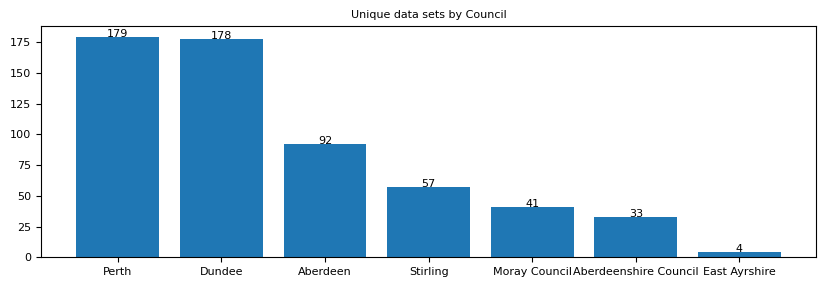

In [69]:
stats_a = data_distinct.groupby(['Owner']).size().reset_index().rename(columns={0:'Count'})
stats_a = stats_a.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,3))
plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_a['Owner'], stats_a['Count'])
plt.title('Unique data sets by Council')
plt.show()

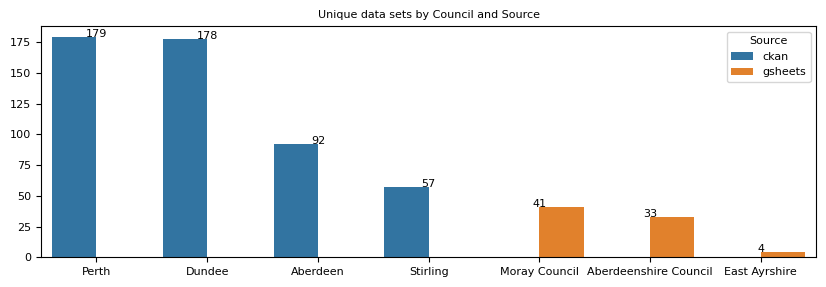

In [83]:
stats_b = data_distinct.groupby(['Owner','Source']).size().reset_index().rename(columns={0:'Count'})
#stats_b = stats_b.pivot(index='Owner',columns='Source', values='count').reset_index()
stats_b = stats_b.sort_values(by=['Count'], ascending=False).reset_index(drop=True)
stats_b

plt.figure(figsize=(10,3))
#plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
sns.barplot(x='Owner', y='Count', data=stats_b, hue='Source')
plt.ylabel(''), plt.xlabel('')
addlabels(stats_b['Owner'], stats_b['Count'])
plt.title('Unique data sets by Council and Source')
plt.show()


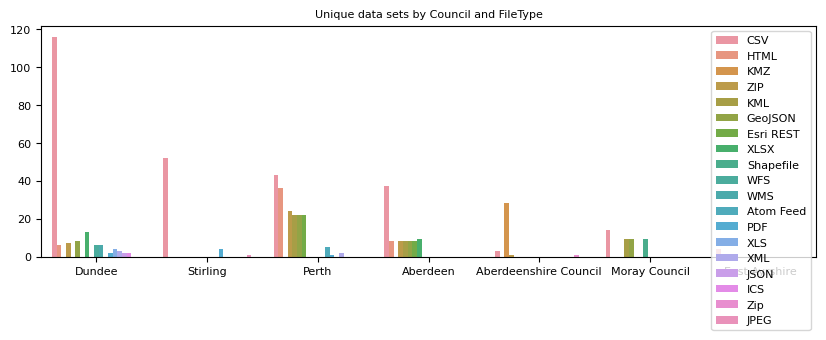

In [86]:
stats_c = data.groupby(['Owner','FileType']).size().reset_index().rename(columns={0:'Count'})
stats_c = stats_c.sort_values(by=['Count'], ascending=False).reset_index(drop=True)
stats_c

plt.figure(figsize=(10,3))
#plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
#addlabels(stats_c['Owner'], stats_c['Count'])
plt.title('Unique data sets by Council and FileType')
plt.legend(loc='upper right')
plt.show()

In [116]:
data_tags['AllTags'] = data_tags.apply(lambda x: str(x['OriginalTags'])+ ';' + str(x['ManualTags']), axis=1)
data_tags['AllTags_Tuple'] = data_tags['AllTags'].str.split(';')

stats_d = data_tags[['Owner','AllTags_Tuple']]
'''
plt.figure(figsize=(10,3))
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
#addlabels(stats_c['Owner'], stats_c['Count'])
plt.title('Unique data sets by Council and FileType')
plt.legend(loc='upper right')
plt.show()
'''
stats_d

,Owner,AllTags_Tuple
0,Aberdeen,"[Aberdeen, Contracts, Finance, nan]"
1,Aberdeen,"[Aberdeen, Military, nan]"
2,Aberdeen,"[Aberdeen, Military, nan]"
3,Aberdeen,"[Aberdeen, Military, nan]"
4,Aberdeen,"[Aberdeen, Military, nan]"
...,...,...
73,Aberdeenshire Council,"[nan, Schools, education]"
74,Aberdeenshire Council,"[nan, Schools, education]"
75,Aberdeenshire Council,"[nan, wind turbines, conservation, energy]"
76,Aberdeenshire Council,"[nan, wind turbines, conservation, energy]"
